In [1]:
import sys
sys.path.insert(1,'../functions/')
import torch
from torch import nn
import numpy as np
import data_sim
import matplotlib.pyplot as plt
import xarray as xr
import copy
import pandas as pd
from torch.utils.data import Dataset, DataLoader
#from slab_spike_model_constructor import *
from full_slab_spike_model_constructor import *
from training_func import *
import pyreadr
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Read in the data

In [2]:
ABCD = pd.read_csv('../dataset/abcd.csv')
list_ROI = pyreadr.read_r('../dataset/ABCD_ROI.list.RData')

/var/folders/cy/7rpv9wdx3nb25gzbj78xgqwm0000gn/T/ipykernel_25743/286607271.py:1: DtypeWarning: Columns (23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  ABCD = pd.read_csv('../dataset/abcd.csv')


In [22]:
from torch.utils.data import Dataset, DataLoader
import os
from sklearn.linear_model import LassoCV,RidgeCV
from sklearn.model_selection import train_test_split

class inference_on_data(object):
    def __init__(self, data, outcome_vars, 
                  modality_vars, modality_vars_dict, 
                  lr = 0.05, batch_size = None, tobit = True, 
                  device = 'cpu', random_seed = 1):
        self.data = data
        self.outcome_vars = outcome_vars
        self.modality_vars = modality_vars
        self.modality_vars_dict = modality_vars_dict
        
        self.lr = lr
        self.batch_size = batch_size
        self.tobit = True
        self.device = device
        self.random_seed = 1
    
    def run(self, outcome_name, modality_name):
        image_var = list(np.squeeze(self.modality_vars_dict[modality_name].values,1))
        cov = image_var.copy()
        cov.extend([outcome_name,'eventname',
            "mri_info_manufacturers.model.name", 'race.6level', 'age', 'female', 'subjectid', 'demo_rel_family_id.bl'])
        #import pdb; pdb.set_trace()
        # getting the relevent columns
        ABCD_sub = self.data.loc[:,np.isin(self.data.columns,cov)]
        # getting the subjects without na
        ABCD_sub = ABCD_sub.loc[~ABCD_sub.isnull().any(axis = 1),:]
        # sample one subject in the families
        ABCD_sub = ABCD_sub.groupby('demo_rel_family_id.bl', 
                                    group_keys=False).apply(lambda x: x.sample(1, random_state = self.random_seed)).reset_index(drop=True)
        # sample one subject in the visit
        ABCD_sub = ABCD_sub.groupby(['subjectid','eventname'], 
                                    group_keys=False).apply(lambda x: x.sample(1, random_state = self.random_seed)).reset_index(drop=True)
        # drop the subjectid and family id
        ABCD_sub.drop(columns = ['subjectid', 'demo_rel_family_id.bl','eventname'], inplace=True)
        # Onehotencode the categorical variables
        cate_cov = ['race.6level', 'female',"mri_info_manufacturers.model.name"]
        OHE = OneHotEncoder(drop = 'first',sparse_output = False).fit(ABCD_sub[cate_cov])
        encoded_cols = list(OHE.get_feature_names_out(cate_cov))
        ABCD_sub[encoded_cols] = OHE.transform(ABCD_sub[cate_cov])
        # Confounders variable
        confounders = encoded_cols+['age']
        # Setting up the numpy array
        X = ABCD_sub[confounders+image_var].to_numpy()
        # Standardization
        scaler = StandardScaler()
        scaler.fit(X)
        X = scaler.transform(X)
        z = ABCD_sub[outcome_name].to_numpy() 
        # smallest value at 0
        z = z- min(z)
        p_confound = len(confounders)
        # Train test split
        X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state=42)

        p = X_train.shape[1] - p_confound
        n = X_train.shape[0]
        # Model setup
        if self.batch_size == None:
            batch_size = X.shape[0]
        else:
            batch_size = batch_size
        #import pdb; pdb.set_trace()
        # Lasso
        reg = LassoCV(cv = 5, alphas = (1,10))
        reg.fit(X_train,z_train)
        z_pred = reg.predict(X_test)
        mse_lasso = np.mean(np.square(z_pred*(z_pred>0)-z_test))
        # Ridge
        reg = RidgeCV(cv = 5, alphas = (1,10))
        reg.fit(X_train,z_train)
        z_pred = reg.predict(X_test)
        mse_ridge = np.mean(np.square(z_pred*(z_pred>0)-z_test))
        exact_lh = True
        tobit = self.tobit
        X_train = torch.tensor(X_train)
        z_train = torch.tensor(z_train)
        X_test = torch.tensor(X_test)
        z_test = torch.tensor(z_test)
        sim_data = Sim_Dataset(X_train, z_train, device = self.device)
        sim_data_loader = DataLoader(sim_data, batch_size = batch_size)
        true_beta = np.zeros((p,))
        model = linear_slab_spike(p = p, n_total = n, p_confound = p_confound,init_pi_local_max = 1.0, 
                                  init_pi_local_min = 0.0,init_pi_global = 0.5, init_beta_var =1, init_noise_var = 1,
                                  gumbel_softmax_temp = 1, gumbel_softmax_hard = False, 
                                  a1= 0.1, a2=0.1, init_a3= 1.1, init_a4 = 1.1,
                                  b1 = 1.1, b2 = 1.1, init_b3 = 10.0, init_b4 = 0.1, n_E = 1
                                  , prior_sparsity = True, prior_sparsity_beta = False,
                                  exact_lh = exact_lh,tobit = self.tobit, device = self.device
                                 ).double().to(self.device)
        optimizer = torch.optim.Adam(model.parameters(),lr = 0.5)
        lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.8)
        t = 100 #number of moving averages
        patience = 200# patience
        best_model, error, point_est, result_dict = train_and_infer(model = model, optimizer = optimizer,
                                                                    sim_data_loader = sim_data_loader, 
                                                                    lr_scheduler = lr_scheduler, t = t, 
                                                                    patience = patience,X = X, plot = True, 
                                                                    true_beta = true_beta, lr_schedule_step = 1000,
                                                                    verbose = False)
        pi_local_est = torch.sigmoid(best_model.logit_pi_local)
        beta_est = best_model.beta_mu
        top_k_pi, indices = torch.topk(pi_local_est, 10)
        top_k_beta_est = beta_est[indices].cpu().detach().numpy()
        top_k_pi = top_k_pi.cpu().detach().numpy()
        indices = indices.numpy()
        top_k_name = np.array(image_var)[indices]
        dict_top_k = {'outcome': np.repeat(outcome_name, len(top_k_name)),
                      'modality':np.repeat(modality_name, len(top_k_name)),
                      'var_name': top_k_name, 'pi':top_k_pi}
        dict_beta_pi = {'beta':beta_est.cpu().detach().numpy(),'pi': pi_local_est.cpu().detach().numpy()}
        result_dict['outcome']=outcome_name
        result_dict['modality'] = modality_name
        z_pred = best_model.predict(X_test)
        result_dict['mse'] = np.mean(np.square(z_pred*(z_pred>0) - z_test.cpu().detach().numpy()))
        result_dict['mse_lasso'] = mse_lasso
        result_dict['mse_ridge'] = mse_ridge
        #import pdb; pdb.set_trace()
        # Transform to dataframe
        result_df = pd.DataFrame(result_dict)
        top_k_df = pd.DataFrame(dict_top_k)
        return result_df, top_k_df, dict_beta_pi, point_est
    
    def full_run(self,save_path = ''):
        result_df_l = []
        top_k_df_l = []
        for o in self.outcome_vars:
            for m in self.modality_vars:
                result_df, top_k_df, dict_beta_pi, point_est = self.run(o, m)
                #import pdb;pdb.set_trace()
                result_df_l.append(result_df)
                top_k_df_l.append(top_k_df)
        total_result = pd.concat(result_df_l)
        top_k_result = pd.concat(top_k_df_l)
        total_result.to_csv(os.path.join(save_path, 'ABCD_h_sparsity.csv'))
        top_k_result.to_csv(os.path.join(save_path, 'ABCD_top_k_variable.csv'))
        return total_result, top_k_result
                

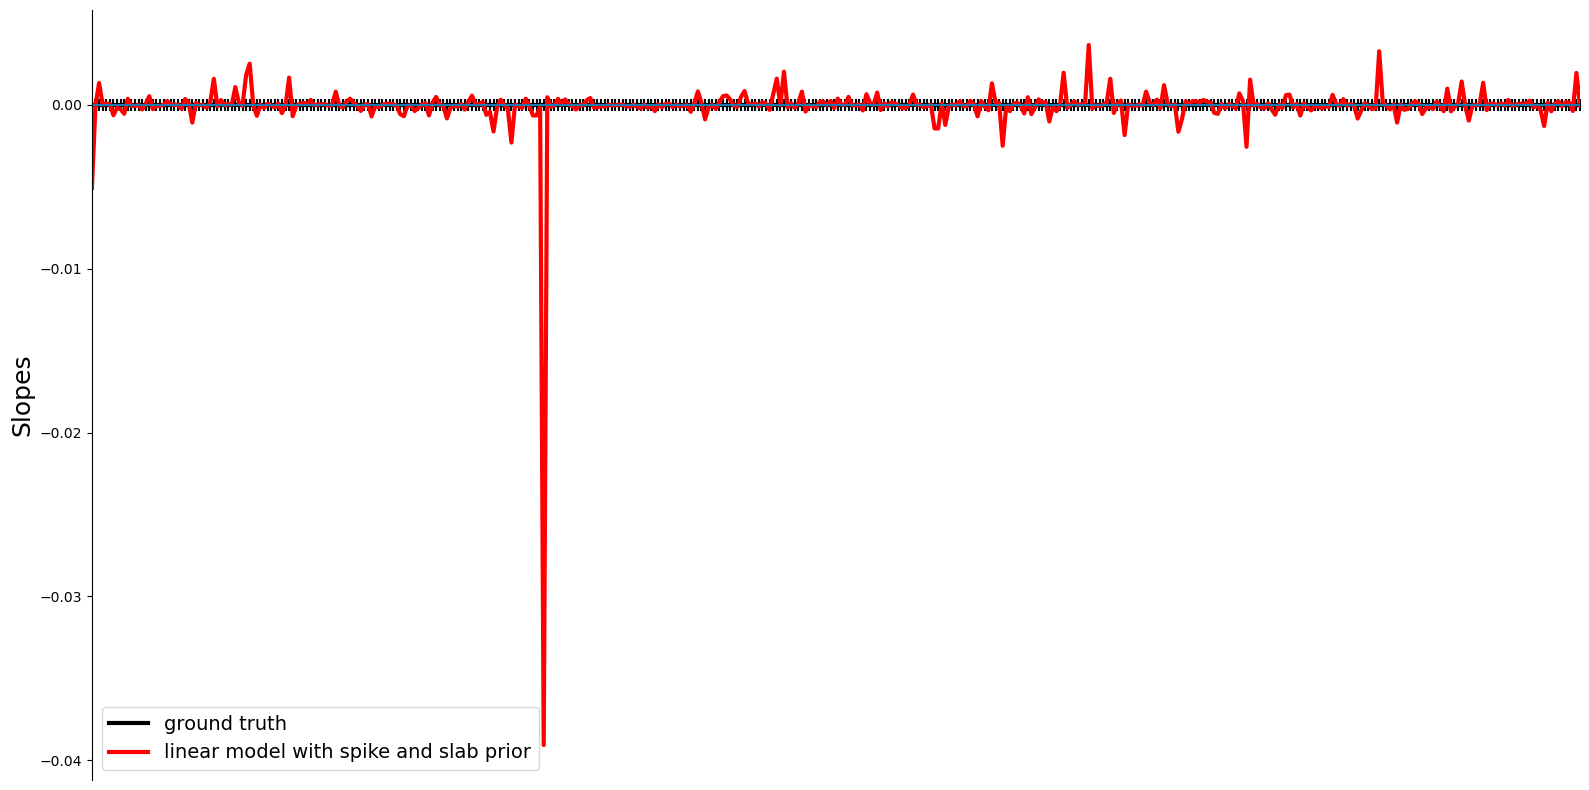

> /var/folders/cy/7rpv9wdx3nb25gzbj78xgqwm0000gn/T/ipykernel_25743/3589868310.py(135)full_run()
    133                 result_df, top_k_df, dict_beta_pi, point_est = self.run(o, m)
    134                 import pdb;pdb.set_trace()
--> 135                 result_df_l.append(result_df)
    136                 top_k_df_l.append(top_k_df)
    137         total_result = pd.concat(result_df_l)



ipdb>  result_df


   mean_h_est  h_est_upper  h_est_lower  mean_var_genetic   noise_var  \
0    0.025469     0.027087     0.024483           3.31148  126.737237   

   global_pi  global_pi_upper  global_pi_lower                  outcome  \
0   0.006077         0.018639         0.000307  cbcl_scr_syn_internal_t   

     modality         mse   mse_lasso   mse_ridge  
0  rsmri_list  114.739148  115.689269  119.524365  


ipdb>  c


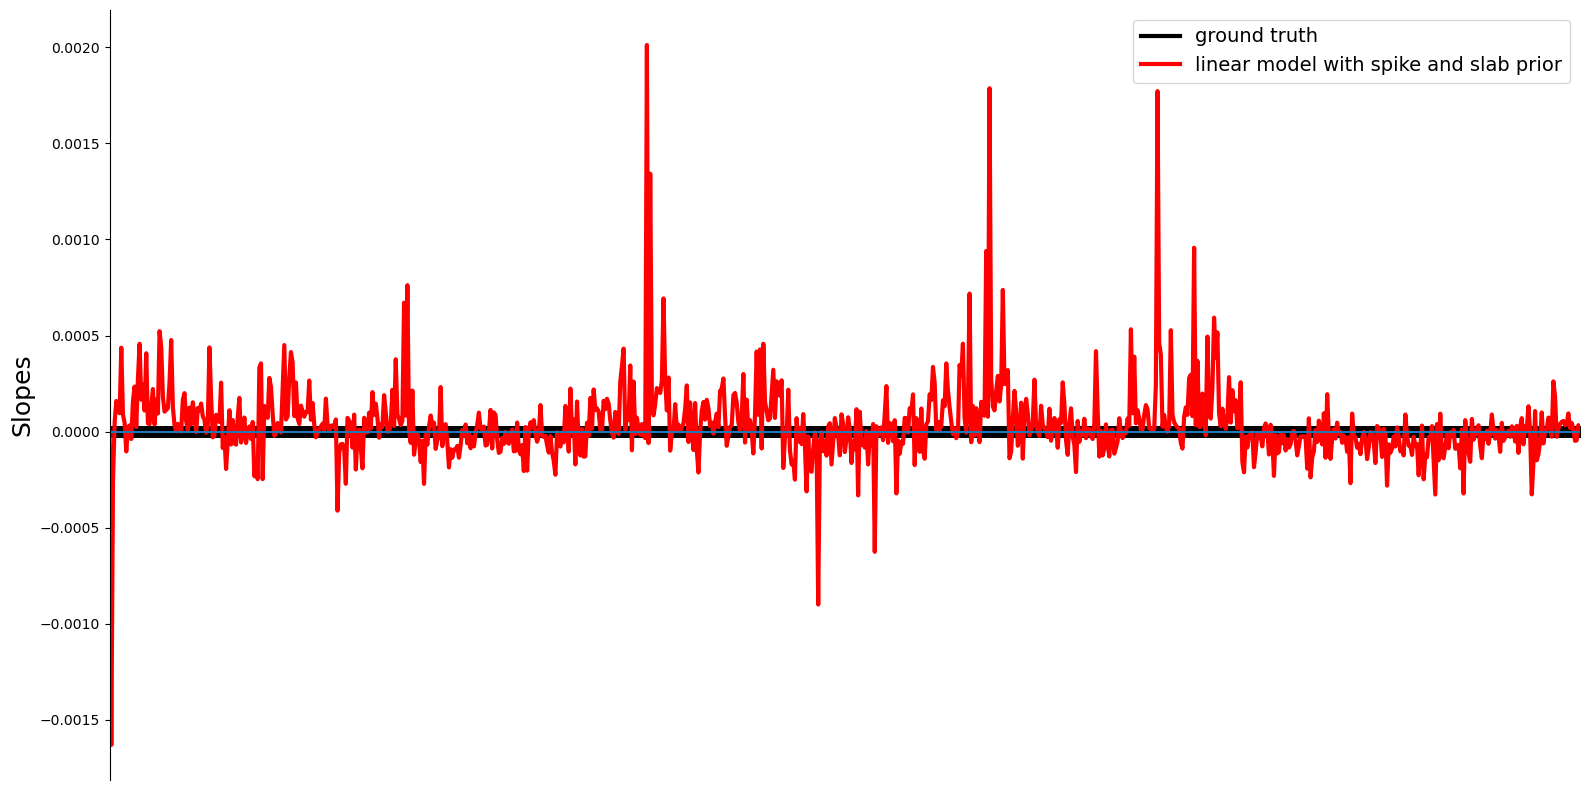

> /var/folders/cy/7rpv9wdx3nb25gzbj78xgqwm0000gn/T/ipykernel_25743/3589868310.py(135)full_run()
    133                 result_df, top_k_df, dict_beta_pi, point_est = self.run(o, m)
    134                 import pdb;pdb.set_trace()
--> 135                 result_df_l.append(result_df)
    136                 top_k_df_l.append(top_k_df)
    137         total_result = pd.concat(result_df_l)



ipdb>  result_df


   mean_h_est  h_est_upper  h_est_lower  mean_var_genetic   noise_var  \
0     0.02641     0.027432     0.025502          3.463389  127.711153   

   global_pi  global_pi_upper  global_pi_lower                  outcome  \
0   0.004208          0.01131         0.000374  cbcl_scr_syn_internal_t   

     modality         mse   mse_lasso   mse_ridge  
0  tfmri_list  108.623148  108.626864  119.570135  


ipdb>  q


In [23]:
outcome_vars = ['cbcl_scr_syn_internal_t', 'cbcl_scr_syn_anxdep_t', 'abcl_scr_sub_use_alcohol_t']
modality_vars = ['rsmri_list', 'tfmri_list', 'smri_list', 'dti_list', 'rsi_list']
temp = inference_on_data(data = ABCD,  
                         outcome_vars = outcome_vars, 
                         modality_vars = modality_vars,
                         modality_vars_dict = list_ROI)
total_result, top_k_result = temp.full_run()